In [267]:
import pandas as pd
import tqdm
from datetime import datetime
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
sns.set_theme(style="darkgrid")

In [5]:
df_timeseries = pd.read_csv("data/df_timeseries_en.tsv", sep="\t")
df_timeseries_2019 = df_timeseries[pd.to_datetime(df_timeseries["datetime"]).dt.year == 2019]

In [6]:
filepath = 'generated/2019/2019_videos_Typo_Emojis_NegWords_Sentiment_title_desc.parquet'
videos = pd.read_parquet(filepath, engine='fastparquet')

# Evolution of channels when posting negative content

In this part, we will try to plot the evolution of channels when posting negative content. The goal is to determine visually a correlation between the negativity of the title and description with the delta of views, subs, likes and dislikes, i.e will posting a video with a negative title impact the success over time ?

We firstly want to merge each video with the corresponding timeserie, to have access to the channel current state at time of upload, such as the delta_subs and delta_views. Since the timeseries might not have been snapshotted at the exact same date as the upload date, we will merge "asof", i.e on the closest date.

In [7]:
df_timeseries_2019["datetime"] = pd.to_datetime(df_timeseries_2019['datetime'])
df_timeseries_2019.rename({"datetime": "nearest_time"}, axis=1, inplace=True)
videos.rename({"upload_date": "nearest_time"}, axis=1, inplace=True)
df_timeseries_2019.rename({"channel": "channel_id"}, axis=1, inplace=True)

In [8]:
videos_timeseries = pd.merge_asof(videos.sort_values("nearest_time"),df_timeseries_2019.sort_values("nearest_time"),on="nearest_time",by="channel_id",allow_exact_matches=True,direction="nearest",tolerance=pd.Timedelta(1,unit="W"))

In [9]:
videos_timeseries.to_csv("data/videos_timeseries.csv")

In [48]:
videos_timeseries = pd.read_csv("data/videos_timeseries.csv")

We want to know what the curves of the deltas look like approximatively for each channel over every week. Since there are too many channels, we will firstly focus on the 100 most successful channels as they might be more representative for an indice of success correlation. 

#### ANALYSIS ON 100 BIGGEST CHANNELS

Since we are interested in the indice of succes, we will only select the 100 channels with the most average views.

In [118]:
most_success_chans = videos_timeseries.groupby("channel_id").apply(lambda channel: channel["views"].mean()).nlargest(100).index.tolist()

In [119]:
videos_per_channel = videos_timeseries.groupby("channel_id")

We will then only keep the videos and timeserie stats corresponding to these 100 most successful (viewed) channels

In [120]:
videos_success_timeseries = pd.DataFrame(columns=videos_timeseries.columns)
for chan_id, chan_vids in tqdm.tqdm(videos_per_channel):
    if chan_id in most_success_chans:
        videos_success_timeseries = videos_success_timeseries.append(chan_vids,ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████| 128543/128543 [00:20<00:00, 6274.48it/s]


We add a "week_idx" column to specify the week for each video. That will be useful to plot the evolution over weeks.

In [121]:
videos_success_timeseries["week_idx"] = pd.to_datetime(videos_success_timeseries["nearest_time"]).dt.isocalendar().week

In [122]:
videos_per_succ_channel = videos_success_timeseries.groupby("channel_id")

In [123]:
len(videos_per_succ_channel)

100

Among these channels, we want channels that are active weekly, to have a stable study throughout the year. For that, we filter out the channels that have weeks where there post less than one video.

In [124]:
# For all videos of a given channel, returns True if at videos posted all weeks, else false
def has_videos_all_weeks(chan_vids):
    vids_per_week = chan_vids.groupby("week_idx")
    for week_idx, vids in vids_per_week:
        if vids["videos"].mean() == 0:
            return False  
    return True      

In [125]:
videos_per_active_succ_channel = videos_per_succ_channel.filter(lambda chan_vids: has_videos_all_weeks(chan_vids)).groupby("channel_id")

We can here see how many channels have been filtered on our original 100 channels

In [126]:
len(videos_per_succ_channel) - len(videos_per_active_succ_channel)

0

As we can see, all the 100 most successful channels are active.

Now, we compute the deltas. To do so, we iterate on each group of videos (for each channel) and group by week. Some weeks might have multiple values, i.e multiple videos posted the same week, for those cases we simply use the mean of the deltas. This way, for each channel, we have the mean of deltas associated to each week. We then compute the delta_sia, delta_like and delta_dislike for each week.

In [127]:
def compute_delta(pred_val,curr_val):
    delta = curr_val - pred_val
    return delta, pred_val

In [679]:
channel_deltas = pd.DataFrame(columns=["channel","week_idx","delta_sia_neg_title","delta_sia_neg_desc","delta_sia_pos_title","delta_sia_pos_desc","delta_sia_neutral_title","delta_sia_neutral_desc","delta_views","delta_like","delta_dislike","delta_videos","delta_subs","delta_sia_compound_title","delta_sia_compound_desc"])
for chan_id, chan_vids in tqdm.tqdm(videos_per_active_succ_channel):   
    
    #Some weeks appear multiple time in the timeseries. We do the mean for each week to obtain the delta.
    chan_vids = chan_vids.groupby("week_idx", as_index=False).mean()   
    chan_vids = chan_vids.set_index('week_idx')
    
    pred_sia_neg_title = 0.0
    pred_sia_neg_desc = 0.0
    pred_sia_pos_title = 0.0
    pred_sia_pos_desc = 0.0
    pred_sia_neutral_title = 0.0
    pred_sia_neutral_desc = 0.0
    pred_like = 0.0
    pred_dislike = 0.0
    pred_sia_compound_desc = 0.0
    pred_sia_compound_title = 0.0
    for week_idx, row in chan_vids.iterrows(): 
        
        # Compute the delta_sia for the three sentiments (positive, neutral and negative)
        delta_sia_neg_title, pred_sia_neg_title = compute_delta(pred_sia_neg_title,row["sia_negative_title"])
        delta_sia_neg_desc, pred_sia_neg_desc = compute_delta(pred_sia_neg_desc,row["sia_negative_description"])
        
        delta_sia_pos_title, pred_pos_neg_title = compute_delta(pred_sia_pos_title,row["sia_positive_title"])
        delta_sia_pos_desc, pred_pos_neg_desc = compute_delta(pred_sia_pos_desc,row["sia_positive_description"])
        
        delta_sia_neutral_title, pred_sia_neutral_title = compute_delta(pred_sia_neutral_title,row["sia_neutral_title"])
        delta_sia_neutral_desc, pred_sia_neutral_desc = compute_delta(pred_sia_neutral_desc,row["sia_neutral_description"])
        
        delta_sia_compound_title, pred_sia_compound_title = compute_delta(pred_sia_compound_title,row["sia_compound_title"])
        delta_sia_compound_desc, pred_sia_compound_desc = compute_delta(pred_sia_compound_desc,row["sia_compound_description"])
        
        delta_like, pred_like = compute_delta(pred_like,row["like_count"])
        delta_dislike, pred_dislike = compute_delta(pred_dislike,row["dislike_count"])
        
        new_row = {'channel': chan_id, 'week_idx': week_idx, 'delta_sia_neg_title': delta_sia_neg_title, "delta_sia_neg_desc": delta_sia_neg_desc, "delta_sia_pos_title": delta_sia_pos_title,"delta_sia_pos_desc": delta_sia_pos_desc, "delta_sia_neutral_title": delta_sia_neutral_title, "delta_sia_neutral_desc": delta_sia_neutral_desc,'delta_views': row["delta_views"],'delta_like': delta_like, 'delta_dislike': delta_dislike, "delta_videos": row["delta_videos"], "delta_subs": row["delta_subs"], "delta_sia_compound_title": delta_sia_compound_title, "delta_sia_compound_desc": delta_sia_compound_desc}
        channel_deltas = channel_deltas.append(new_row, ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.82it/s]


In [680]:
chan_deltas_grouped = channel_deltas.groupby("channel")

## Study of a sample of channels

We choose a random sample among the 100 most sucessful channels: 

In [695]:
n = 1
a=np.arange(chan_deltas_grouped.ngroups)
np.random.shuffle(a)
print(a[:n]) #channel UCRijo3ddMTht_IHyNSNXpNQ for the observation
sample_channel_deltas = channel_deltas[chan_deltas_grouped.ngroup().isin(a[:n])].groupby("channel")

[87]


Now, let's try plotting the sample (normalizing the columns so that they are all on same scale)

In [696]:
def normalize(df):
    df_ = df.drop(["channel"],axis=1)
    df_ = df_.drop(["week_idx"],axis=1)
    df_ = df_.dropna()
    df_norm = (df_-df_.mean())/df_.std()
    df_norm = pd.concat([df.week_idx,df_norm],axis=1)
    return df_norm

sample channe is UCpGdL9Sn3Q5YWUH2DVUW1Ug


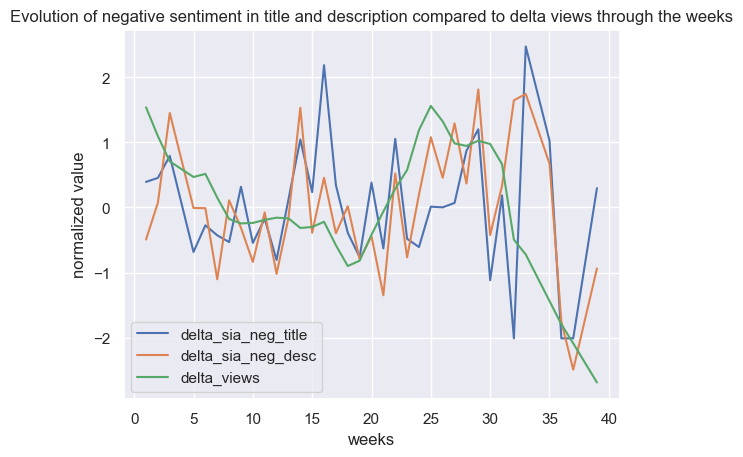

In [697]:
# Negative title, desc compared to views
for chan_id, chan_deltas in sample_channel_deltas:
    print("sample channe is " + chan_id)
    chan_deltas_norm = normalize(chan_deltas)
    chan_deltas_norm.plot(x="week_idx",y=["delta_sia_neg_title","delta_sia_neg_desc","delta_views"], xlabel="weeks",ylabel="normalized value", title="Evolution of negative sentiment in title and description compared to delta views through the weeks")

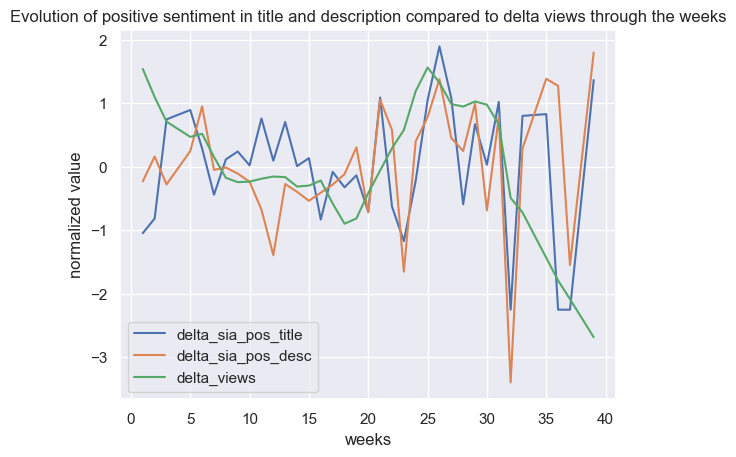

In [699]:
# Positive title, desc compared to views
for chan_id, chan_deltas in sample_channel_deltas:
    chan_deltas_norm = normalize(chan_deltas)
    chan_deltas_norm.plot(x="week_idx",y=["delta_sia_pos_title","delta_sia_pos_desc","delta_views"], xlabel="weeks",ylabel="normalized value", title="Evolution of positive sentiment in title and description compared to delta views through the weeks")

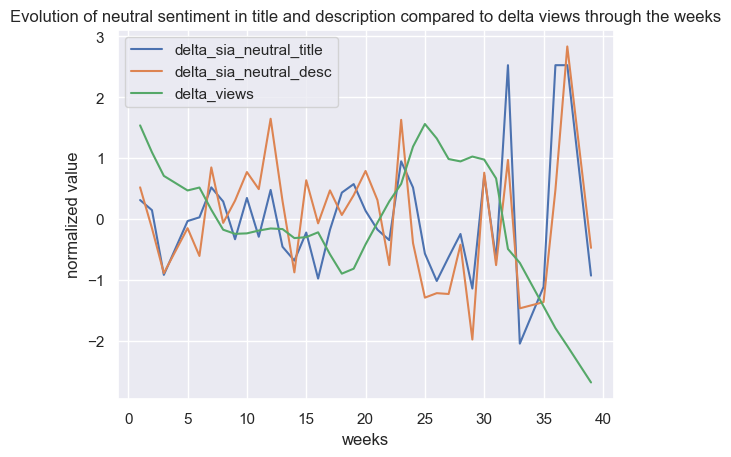

In [700]:
# Neutral title, desc compared to views
for chan_id, chan_deltas in sample_channel_deltas:
    chan_deltas_norm = normalize(chan_deltas)
    chan_deltas_norm.plot(x="week_idx",y=["delta_sia_neutral_title","delta_sia_neutral_desc","delta_views"], xlabel="weeks",ylabel="normalized value", title="Evolution of neutral sentiment in title and description compared to delta views through the weeks")

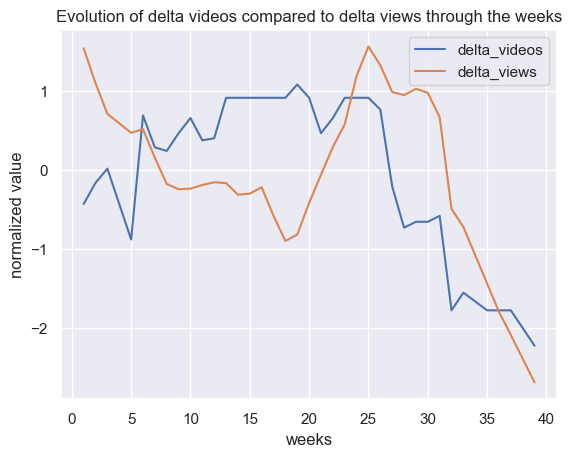

In [701]:
# delta videos compared to views
for chan_id, chan_deltas in sample_channel_deltas:
    chan_deltas_norm = normalize(chan_deltas)
    chan_deltas_norm.plot(x="week_idx",y=["delta_videos","delta_views"], xlabel="weeks",ylabel="normalized value", title="Evolution of delta videos compared to delta views through the weeks")